<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Toxic_comment_multi_label_classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of contents


1. [Introduction](#1)
2. [Import packages](#2)
3. [Constants](#3)
4. [Load data](#4)
5. [EDA](#5)
6. [Data preparation](#6)
    1. [Tokenization](#6.1)
    2. [Padding](#6.2)
    3. [Split dataset](#6.3)
7. [Model](#7)
8. [Loss function](#8)
9. [Train model](#9)
10. [Model evaluation](#10)
11. [Test model](#11)
12. [References](#12)




## Introduction <a name="1"></a>

In this notebook, we build a multi-label classification model that’s capable of detecting different types of toxicity like threats, obscenity, insults, etc, using a dataset of comments from Wikipedia’s talk page edits. The description of the problem and the dataset is available in [Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).

## Import packages <a name="2"></a>

In [132]:
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import (Dense, Embedding, Input, LSTM, Bidirectional, 
                          GlobalMaxPool1D, Dropout)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.backend import mean, binary_crossentropy
import tensorflow as tf
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Constants <a name="3"></a>

In [134]:
DATA_PATH = '/content/drive/MyDrive/datasets/toxic_comments/train.csv'
# Maximum number of words to keep when tokenize text (based on word frequency)
MAX_WORDS_NUMBER = 2000
# Maximum length of all sequences 
MAX_SEQUENCE_LENGTH = 150
# Size of the word embeddings
EMBEDDING_SIZE = 128
EPOCHS_NUMBER = 2
BATCH_SIZE = 32
# Threshold for interpreting probabilities
THRESHOLD = 0.5

## Load data <a name="4"></a>

In [135]:
source_df = pd.read_csv(DATA_PATH)  
comments_number = source_df.shape[0]
print(f'Number of comments in the dataset: {comments_number}')
source_df.head(7) 

Number of comments in the dataset: 159571


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


We can see that each comment can be assigned to more than one category. So this is a **multi-label classification** problem.

In [136]:
label_names = list(source_df.columns[2:])
labels_number = len(label_names)
print(f'Name of the labels: {label_names}')

Name of the labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


## EDA <a name="5"></a>

We see the number of comments which are assigned to each category.

Text(0.5, 0, 'Number of comments')

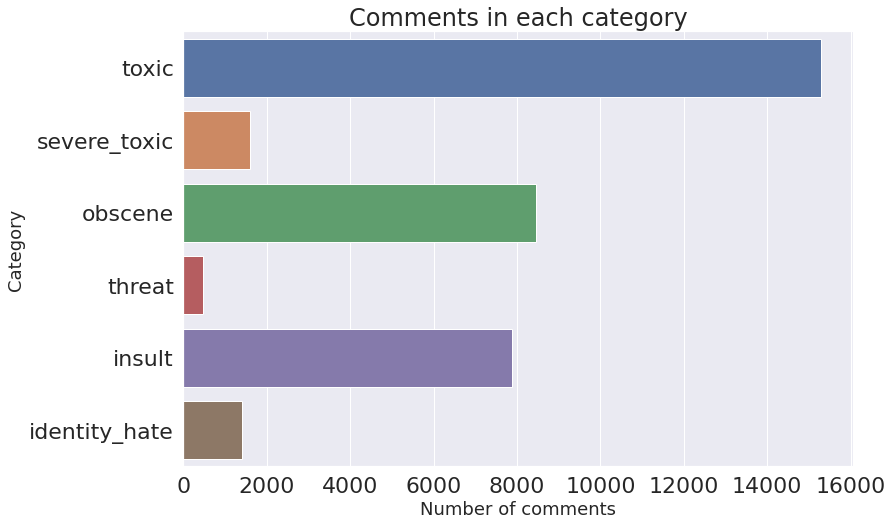

In [137]:
sns.set(font_scale = 2)
plt.figure(figsize=(12,8))
ax= sns.barplot(y=label_names, x=source_df[label_names].sum().values, orient="h")
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Category', fontsize=18)
plt.xlabel('Number of comments', fontsize=18)

The dataset is **imbalanced**. 

Now, let's see the number of comments that have multiple labels.

Text(0.5, 0, 'Number of labels')

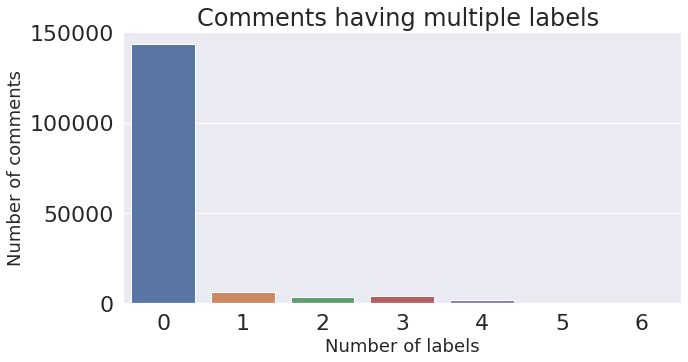

In [138]:
row_sums = source_df[label_names].sum(axis=1)
multiLabel_counts = row_sums.value_counts()
sns.set(font_scale = 2)
plt.figure(figsize=(10,5))
ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

We see the number of words contained in each comment.

Statistics:
count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_text, dtype: float64

Histogram


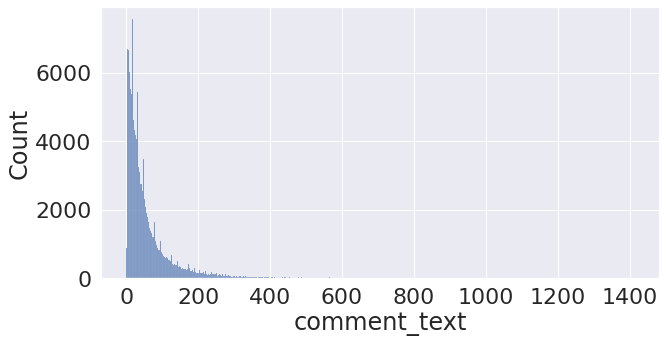

In [139]:
# Get the number of words of each comment
words_number = source_df.comment_text.apply(lambda x: len(x.split()))
print(f'Statistics:\n{words_number.describe()}')
print('\nHistogram')
plt.figure(figsize=(10,5))
sns.histplot(data=words_number, x=words_number)

## Data preparation <a name="6"></a>

In [140]:
X = source_df.comment_text
y = source_df[label_names].values
y.shape

(159571, 6)

### Tokenization <a name="6.1"></a>

In [141]:
tokenizer = Tokenizer(num_words = MAX_WORDS_NUMBER)
tokenizer.fit_on_texts(list(X))

In [142]:
X_tokenized = tokenizer.texts_to_sequences(X)
print(X_tokenized[0])

[688, 75, 1, 126, 130, 177, 29, 672, 1116, 86, 331, 51, 50, 15, 60, 148, 7, 34, 117, 1221, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 89, 985]


### Padding <a name="6.2"></a>

In [143]:
X_padded = sequence.pad_sequences(X_tokenized, maxlen=MAX_SEQUENCE_LENGTH)
print(X_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  688   75    1  126  130  177   29  672 1116   86
  331   51   50   15   60  148    7   34  117 1221    4   45   59  244
    1  365   31    1   38   27  143   73   89  985]


### Split dataset <a name="6.3"></a>

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
     X_padded, y, test_size = 0.2, random_state=1, shuffle=True)

## Model <a name="7"></a>

In [145]:
def model():
    inputs = Input(shape = (MAX_SEQUENCE_LENGTH, ))
    layer = Embedding(MAX_WORDS_NUMBER, EMBEDDING_SIZE)(inputs)
    layer = Bidirectional(LSTM(50, return_sequences = True))(layer)
    layer = GlobalMaxPool1D()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(50, activation = 'relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(labels_number, activation = 'sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    
    return model

## Loss function <a name="8"></a>

We saw previously that the dataset is imbalanced. We are going to build our own binary cross-entropy loss function in which we multiply our weights ourselves. First, we calculate the weights using the [`compute_class_weight`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) Scikit-learn util function.

In [146]:
def calculate_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0,1], y_true[:, i])
    return weights
class_weights = calculate_class_weights(y_train)
class_weights

array([[  0.55279089,   5.23566565],
       [  0.50511222,  49.40247678],
       [  0.52796665,   9.43921917],
       [  0.501481  , 169.30503979],
       [  0.52596969,  10.12660638],
       [  0.50442163,  57.04021448]])

We define the custom binary cross-entropy loss function.

In [147]:
def get_weighted_loss(class_weights):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        weights = (class_weights[:,0]**(1-y_true))*(class_weights[:,1]**(y_true))
        loss_weighted = mean(weights*binary_crossentropy(y_true, y_pred), axis=-1)
        return loss_weighted
    return weighted_loss

In [148]:
model = model()
model.compile(loss=get_weighted_loss(class_weights), optimizer = 'adam', 
              metrics=[tf.keras.metrics.AUC(multi_label=True)])

## Train model <a name="9"></a>

In [149]:
hist = model.fit(X_train, y_train, batch_size = BATCH_SIZE, 
                 epochs = EPOCHS_NUMBER, 
                 validation_data = (X_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 79s 19ms/step - loss: 0.3553 - auc_6: 0.9033 - val_loss: 0.2374 - val_auc_6: 0.9658
Epoch 2/2
3990/3990 [==============================] - 75s 19ms/step - loss: 0.1986 - auc_6: 0.9709 - val_loss: 0.2421 - val_auc_6: 0.9666


## Model evaluation <a name="10"></a>

In [150]:
y_val_pred_proba = model.predict(X_val)

In [151]:
auc = tf.keras.metrics.AUC(multi_label=True)
print(f'Macro Auc: {auc(y_val, y_val_pred_proba)}')

Macro Auc: 0.966592013835907


In [152]:
y_val_pred = np.array([[1 if i > THRESHOLD else 0 for i in j] 
                       for j in y_val_pred_proba])
print('Classification report:\n'
      f'{classification_report(y_val, y_val_pred, zero_division=0)}')
confusion_matrices = multilabel_confusion_matrix(y_val, y_val_pred)
print(f'Confusion matrices:\n{confusion_matrices}')

Classification report:
              precision    recall  f1-score   support

           0       0.48      0.87      0.62      3103
           1       0.14      0.97      0.24       303
           2       0.46      0.91      0.61      1687
           3       0.04      0.90      0.08       101
           4       0.34      0.91      0.50      1574
           5       0.07      0.92      0.13       286

   micro avg       0.30      0.90      0.44      7054
   macro avg       0.26      0.91      0.36      7054
weighted avg       0.41      0.90      0.55      7054
 samples avg       0.04      0.09      0.05      7054

Confusion matrices:
[[[25900  2912]
  [  394  2709]]

 [[29805  1807]
  [   10   293]]

 [[28415  1813]
  [  145  1542]]

 [[29585  2229]
  [   10    91]]

 [[27589  2752]
  [  145  1429]]

 [[28077  3552]
  [   24   262]]]


Note that the precision score (and hence the f1-score) are affected by the unbalanced evaluation dataset. 

We can compute the confusion matrices with normalization by class support size (number of elements in each class). This kind of normalization can be interesting in case of class imbalance to have a more visual interpretation of which class is being misclassified.

In [153]:
for index, cm in enumerate(confusion_matrices):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(f'Confusion matrix normalized for class "{label_names[index]}"'
          f':\n{np.round(cm,2)}')
    tp_and_fn = cm.sum(1)
    tp_and_fp = cm.sum(0)
    tp = cm.diagonal()
    precision = tp / tp_and_fp
    recall = tp / tp_and_fn
    f1_score = 2*(precision[1]*recall[1])/(precision[1]+recall[1])
    print(f'Precision: {precision[1]:.2f}\nRecall: {recall[1]:.2f}\n'
          f'F-score: {f1_score:.2f}\n')

Confusion matrix normalized for class "toxic":
[[0.9  0.1 ]
 [0.13 0.87]]
Precision: 0.90
Recall: 0.87
F-score: 0.88

Confusion matrix normalized for class "severe_toxic":
[[0.94 0.06]
 [0.03 0.97]]
Precision: 0.94
Recall: 0.97
F-score: 0.96

Confusion matrix normalized for class "obscene":
[[0.94 0.06]
 [0.09 0.91]]
Precision: 0.94
Recall: 0.91
F-score: 0.93

Confusion matrix normalized for class "threat":
[[0.93 0.07]
 [0.1  0.9 ]]
Precision: 0.93
Recall: 0.90
F-score: 0.91

Confusion matrix normalized for class "insult":
[[0.91 0.09]
 [0.09 0.91]]
Precision: 0.91
Recall: 0.91
F-score: 0.91

Confusion matrix normalized for class "identity_hate":
[[0.89 0.11]
 [0.08 0.92]]
Precision: 0.89
Recall: 0.92
F-score: 0.90



## Test model <a name="11"></a>

In [154]:
for index in range(10):

    test_comment_tokenized = X_val[index]
    test_comment = tokenizer.sequences_to_texts([test_comment_tokenized])[0]
    comment_labels = [label_names[i] for i in range(labels_number) if y_val[index][i]]
    pred_proba = model.predict(np.expand_dims(test_comment_tokenized, 0))
    pred = np.array([1 if i > THRESHOLD else 0 for i in pred_proba[0]])
    labels_predicted = [label_names[i] for i in range(labels_number) if pred[i]]
    print(f'\nText of the comment: {test_comment}')
    print(f'True labels of the comment: {comment_labels}')
    print(f'Predicted labels: {labels_predicted}')


Text of the comment: you are a fat who has nothing to do on a but wikipedia i hope you under your own
True labels of the comment: ['toxic', 'severe_toxic', 'obscene', 'insult']
Predicted labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Text of the comment: i've been that they don't to when another would probably be to use one of the used data in it is also here that we to mention that they are used for down i've sent you proof of that see the discussion page where i quoted the two media article discussing the german on back to 4 05 it to be mentioned in that same that there is reason to believe that there also exist more versions for the use through the military etc which are probably more can be placed and still work without external and have a long life potential abuse of what is said in the box is basically correct could it be re in a way to people's interest rather than a for lack of something along the line that are military style thus hard to an

## References <a name="12"></a>


- [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

- [Multi-label classification with class weights in keras](https://stackoverflow.com/questions/48485870/multi-label-classification-with-class-weights-in-keras)

- [Plot confusion matrix Scikit-learn](https://scikit-learn.org/0.20/auto_examples/model_selection/plot_confusion_matrix.html)